In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from mlp import NN

Loading model.

In [2]:
num_classes = 4
size_layers2 = [2, 32, 32, 32, num_classes]
size_layers10 = [10, 32, 32, 32, num_classes]
dropout_layers = [0, 0, 0, 0]

mlp2 = NN(size_layers2, dropout_layers, nn.ReLU(), device='cpu')
mlp10 = NN(size_layers10, dropout_layers, nn.ReLU(), device='cpu')

In [3]:
model2 = torch.load('best_models/mlp_ld2.pth', map_location=torch.device('cpu'), weights_only=True)
model10 = torch.load('best_models/mlp_ld10.pth', map_location=torch.device('cpu'), weights_only=True)

mlp2.load_state_dict(model2)
mlp10.load_state_dict(model10)

<All keys matched successfully>

## Learning Curves

Plotting learning curves.

In [4]:
loss_train2 = np.load('best_models/loss_train_mlp_ld2.npy')
loss_test2 = np.load('best_models/loss_test_mlp_ld2.npy')
loss_train10 = np.load('best_models/loss_train_mlp_ld10.npy')
loss_test10 = np.load('best_models/loss_test_mlp_ld10.npy')

epochs2 = [i for i in range(loss_train2.shape[0])]
epochs10 = [i for i in range(loss_train10.shape[0])]

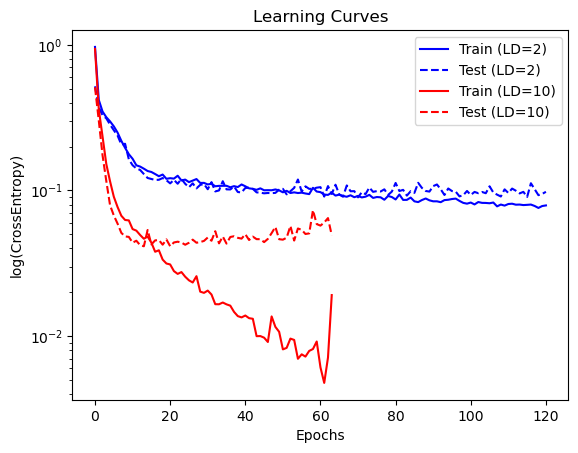

In [5]:
plt.plot(epochs2, loss_train2, label='Train (LD=2)', c='blue')
plt.plot(epochs2, loss_test2, label='Test (LD=2)', c='blue', linestyle='--')
plt.plot(epochs10, loss_train10, label='Train (LD=10)', c='red')
plt.plot(epochs10, loss_test10, label='Test (LD=10)', c='red', linestyle='--')

plt.yscale('log')
plt.ylabel('log(CrossEntropy)')
plt.xlabel('Epochs')
plt.title('Learning Curves')
plt.legend()
plt.show()

## Model avaliation

Loading data for latent space equal to 2.

In [6]:
data_auau_ld2 = torch.tensor(np.load(f"ld2_auau_all.npy"), dtype=torch.float32)
data_ausio2_ld2 = torch.tensor(np.load(f"ld2_ausio2_all.npy"), dtype=torch.float32)
data_ligcl_ld2 = torch.tensor(np.load(f"ld2_ligcl_all.npy"), dtype=torch.float32)
data_ligsio2_ld2 = torch.tensor(np.load(f"ld2_ligsio2_all.npy"), dtype=torch.float32)

labels_auau_ld2 = torch.zeros(len(data_auau_ld2), dtype=torch.long)
labels_ausio2_ld2 = torch.ones(len(data_ausio2_ld2), dtype=torch.long)
labels_ligcl_ld2 = torch.full((len(data_ligcl_ld2),), 2, dtype=torch.long)
labels_ligsio2_ld2 = torch.full((len(data_ligsio2_ld2),), 3, dtype=torch.long)

data_ld2 = torch.cat([data_auau_ld2, data_ausio2_ld2, data_ligcl_ld2, data_ligsio2_ld2], dim=0)
labels_ld2 = torch.cat([labels_auau_ld2, labels_ausio2_ld2, labels_ligcl_ld2, labels_ligsio2_ld2], dim=0)

dataset_ld2 = TensorDataset(data_ld2, labels_ld2)

total_size = len(dataset_ld2)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset_ld2, test_dataset_ld2 = random_split(
    dataset_ld2, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42) 
)

batch_size = 32 
train_loader_ld2 = DataLoader(train_dataset_ld2, batch_size=batch_size, shuffle=True)
test_loader_ld2 = DataLoader(test_dataset_ld2, batch_size=batch_size, shuffle=False)

def check_proportions(loader):
    counts = torch.zeros(4)
    for _, labels in loader:
        for i in range(4):
            counts[i] += (labels == i).sum()
    return counts / counts.sum()

print("Train proportions:", check_proportions(train_loader_ld2))
print("Test proportions:", check_proportions(test_loader_ld2))

Train proportions: tensor([0.2509, 0.2442, 0.2506, 0.2543])
Test proportions: tensor([0.2463, 0.2732, 0.2476, 0.2329])


Testing.

In [7]:
mlp2.eval()  

all_preds_ld2 = []
all_labels_ld2 = []

with torch.no_grad():  
    for inputs, labels in test_loader_ld2:
        outputs = mlp2(inputs)  
        _, preds = torch.max(outputs, 1)  
        all_preds_ld2.append(preds)
        all_labels_ld2.append(labels)

y_pred_ld2 = torch.cat(all_preds_ld2)
y_test_ld2 = torch.cat(all_labels_ld2)

Plotting the confusion matrix.

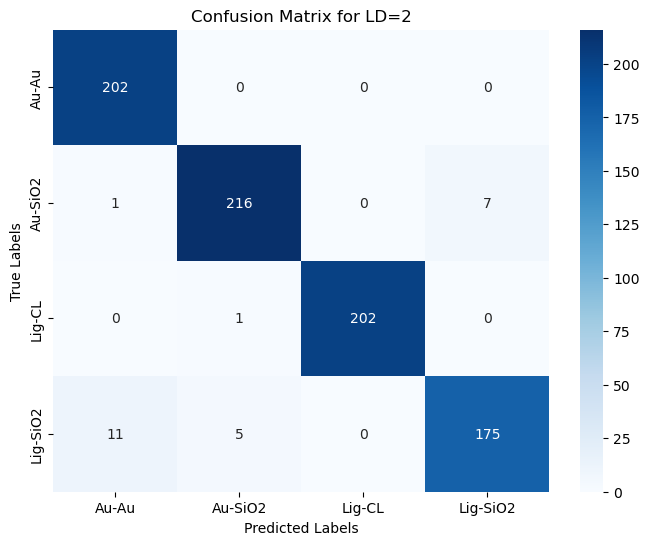

In [8]:
y_pred = y_pred_ld2.numpy()
y_true = y_test_ld2.numpy()

cm = confusion_matrix(y_true, y_pred)
class_names = ['Au-Au', 'Au-SiO2', 'Lig-CL', 'Lig-SiO2']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for LD=2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Doing the same for latent space equal to 10.

In [9]:
data_auau_ld10 = torch.tensor(np.load(f"ld10_auau_all.npy"), dtype=torch.float32)
data_ausio2_ld10 = torch.tensor(np.load(f"ld10_ausio2_all.npy"), dtype=torch.float32)
data_ligcl_ld10 = torch.tensor(np.load(f"ld10_ligcl_all.npy"), dtype=torch.float32)
data_ligsio2_ld10 = torch.tensor(np.load(f"ld10_ligsio2_all.npy"), dtype=torch.float32)

labels_auau_ld10 = torch.zeros(len(data_auau_ld10), dtype=torch.long)
labels_ausio2_ld10 = torch.ones(len(data_ausio2_ld10), dtype=torch.long)
labels_ligcl_ld10 = torch.full((len(data_ligcl_ld10),), 2, dtype=torch.long)
labels_ligsio2_ld10 = torch.full((len(data_ligsio2_ld10),), 3, dtype=torch.long)

data_ld10 = torch.cat([data_auau_ld10, data_ausio2_ld10, data_ligcl_ld10, data_ligsio2_ld10], dim=0)
labels_ld10 = torch.cat([labels_auau_ld10, labels_ausio2_ld10, labels_ligcl_ld10, labels_ligsio2_ld10], dim=0)

dataset_ld10 = TensorDataset(data_ld10, labels_ld10)

total_size = len(dataset_ld10)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset_ld10, test_dataset_ld10 = random_split(
    dataset_ld10, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42) 
)

batch_size = 32 
train_loader_ld10 = DataLoader(train_dataset_ld10, batch_size=batch_size, shuffle=True)
test_loader_ld10 = DataLoader(test_dataset_ld10, batch_size=batch_size, shuffle=False)

def check_proportions(loader):
    counts = torch.zeros(4)
    for _, labels in loader:
        for i in range(4):
            counts[i] += (labels == i).sum()
    return counts / counts.sum()

print("Train proportions:", check_proportions(train_loader_ld10))
print("Test proportions:", check_proportions(test_loader_ld10))

Train proportions: tensor([0.2509, 0.2442, 0.2506, 0.2543])
Test proportions: tensor([0.2463, 0.2732, 0.2476, 0.2329])


Testing:

In [10]:
mlp10.eval()  

all_preds_ld10 = []
all_labels_ld10 = []

with torch.no_grad():  
    for inputs, labels in test_loader_ld10:
        outputs = mlp10(inputs)  
        _, preds = torch.max(outputs, 1)  
        all_preds_ld10.append(preds)
        all_labels_ld10.append(labels)

y_pred_ld10 = torch.cat(all_preds_ld10)
y_test_ld10 = torch.cat(all_labels_ld10)

Plotting the confusion matrix.

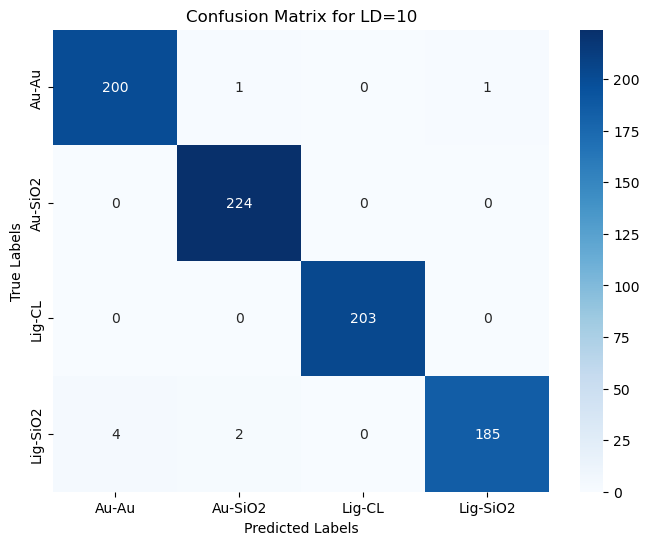

In [11]:
y_pred = y_pred_ld10.numpy()
y_true = y_test_ld10.numpy()

cm = confusion_matrix(y_true, y_pred)
class_names = ['Au-Au', 'Au-SiO2', 'Lig-CL', 'Lig-SiO2']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for LD=10')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Latent Space

Plotting the latent space for LD=2.

In [12]:
ld2_auau = np.load('ld2_auau_all.npy')
ld2_ausio2 = np.load('ld2_ausio2_all.npy')
ld2_ligcl = np.load('ld2_ligcl_all.npy')
ld2_ligsio2 = np.load('ld2_ligsio2_all.npy')

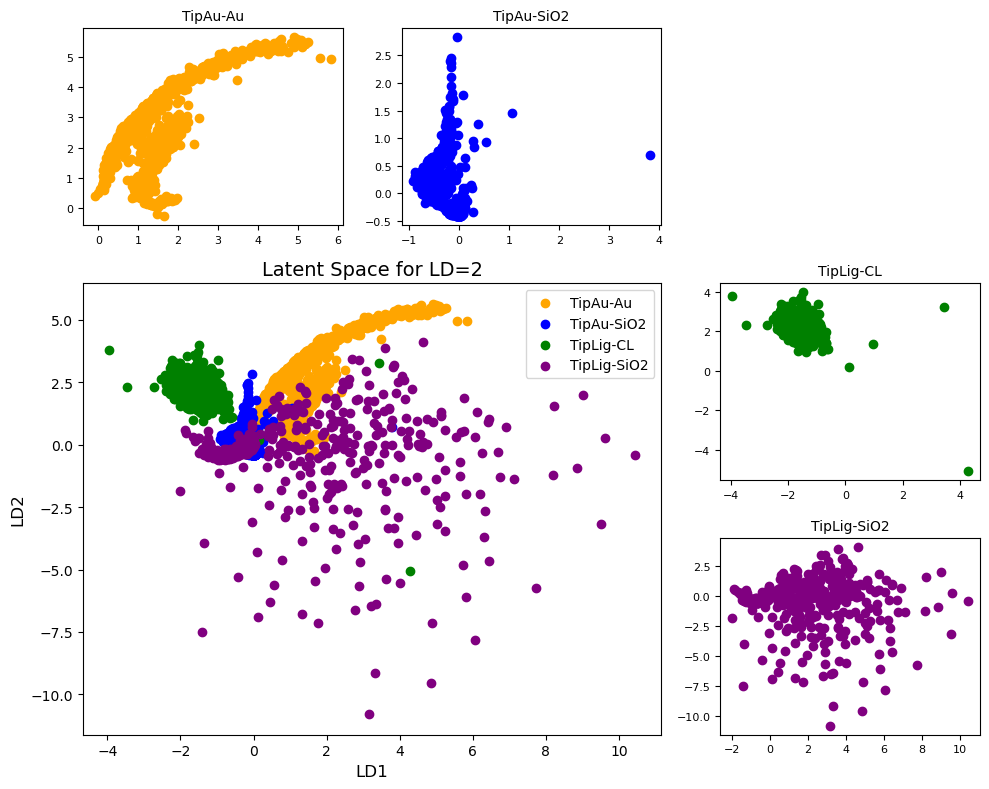

In [13]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 3)  
ax_main = plt.subplot(gs[1:3, 0:2])  

ax1 = plt.subplot(gs[0, 0])  
ax2 = plt.subplot(gs[0, 1])  
ax3 = plt.subplot(gs[1, 2])  
ax4 = plt.subplot(gs[2, 2])  

ax1.scatter(ld2_auau[:, 0], ld2_auau[:, 1], c='orange')
ax1.set_title('TipAu-Au', fontsize=10)
ax1.tick_params(labelsize=8)

ax2.scatter(ld2_ausio2[:, 0], ld2_ausio2[:, 1], c='blue')
ax2.set_title('TipAu-SiO2', fontsize=10)
ax2.tick_params(labelsize=8)

ax3.scatter(ld2_ligcl[:, 0], ld2_ligcl[:, 1], c='green')
ax3.set_title('TipLig-CL', fontsize=10)
ax3.tick_params(labelsize=8)

ax4.scatter(ld2_ligsio2[:, 0], ld2_ligsio2[:, 1], c='purple')
ax4.set_title('TipLig-SiO2', fontsize=10)
ax4.tick_params(labelsize=8)

ax_main.scatter(ld2_auau[:, 0], ld2_auau[:, 1], label='TipAu-Au', c='orange')
ax_main.scatter(ld2_ausio2[:, 0], ld2_ausio2[:, 1], label='TipAu-SiO2', c='blue')
ax_main.scatter(ld2_ligcl[:, 0], ld2_ligcl[:, 1], label='TipLig-CL', c='green')
ax_main.scatter(ld2_ligsio2[:, 0], ld2_ligsio2[:, 1], label='TipLig-SiO2', c='purple')
ax_main.set_xlabel('LD1', fontsize=12)
ax_main.set_ylabel('LD2', fontsize=12)
ax_main.set_title('Latent Space for LD=2', fontsize=14)
ax_main.legend(fontsize=10)

plt.tight_layout()
plt.show()

Plotting the latent space for LD=10.

In [14]:
ld10_auau = np.load('ld10_auau_all.npy')
ld10_ausio2 = np.load('ld10_ausio2_all.npy')
ld10_ligcl = np.load('ld10_ligcl_all.npy')
ld10_ligsio2 = np.load('ld10_ligsio2_all.npy')

pca = PCA(n_components=2)

ld10_auau_pca = pca.fit_transform(ld10_auau)
ld10_ausio2_pca = pca.fit_transform(ld10_ausio2)
ld10_ligcl_pca = pca.fit_transform(ld10_ligcl)
ld10_ligsio2_pca = pca.fit_transform(ld10_ligsio2)

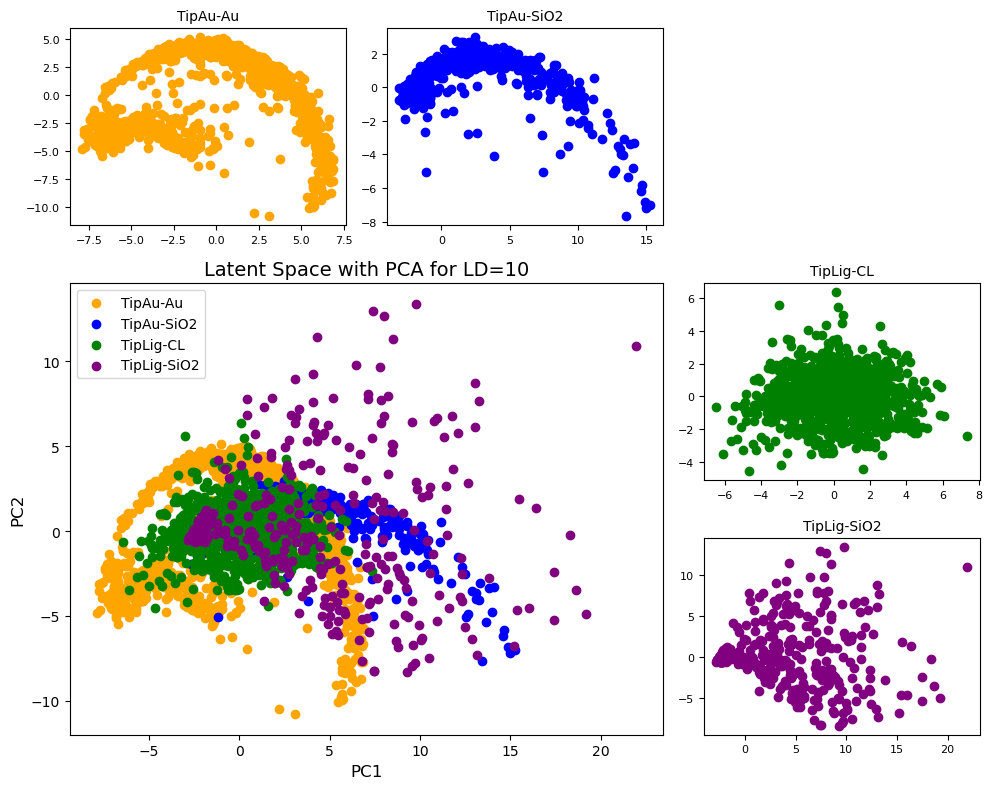

In [15]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 3)  
ax_main = plt.subplot(gs[1:3, 0:2])  

ax1 = plt.subplot(gs[0, 0])  
ax2 = plt.subplot(gs[0, 1])  
ax3 = plt.subplot(gs[1, 2])  
ax4 = plt.subplot(gs[2, 2])  

ax1.scatter(ld10_auau_pca[:, 0], ld10_auau_pca[:, 1], c='orange')
ax1.set_title('TipAu-Au', fontsize=10)
ax1.tick_params(labelsize=8)

ax2.scatter(ld10_ausio2_pca[:, 0], ld10_ausio2_pca[:, 1], c='blue')
ax2.set_title('TipAu-SiO2', fontsize=10)
ax2.tick_params(labelsize=8)

ax3.scatter(ld10_ligcl_pca[:, 0], ld10_ligcl_pca[:, 1], c='green')
ax3.set_title('TipLig-CL', fontsize=10)
ax3.tick_params(labelsize=8)

ax4.scatter(ld10_ligsio2_pca[:, 0], ld10_ligsio2_pca[:, 1], c='purple')
ax4.set_title('TipLig-SiO2', fontsize=10)
ax4.tick_params(labelsize=8)

ax_main.scatter(ld10_auau_pca[:, 0], ld10_auau_pca[:, 1], label='TipAu-Au', c='orange')
ax_main.scatter(ld10_ausio2_pca[:, 0], ld10_ausio2_pca[:, 1], label='TipAu-SiO2', c='blue')
ax_main.scatter(ld10_ligcl_pca[:, 0], ld10_ligcl_pca[:, 1], label='TipLig-CL', c='green')
ax_main.scatter(ld10_ligsio2_pca[:, 0], ld10_ligsio2_pca[:, 1], label='TipLig-SiO2', c='purple')
ax_main.set_xlabel('PC1', fontsize=12)
ax_main.set_ylabel('PC2', fontsize=12)
ax_main.set_title('Latent Space with PCA for LD=10', fontsize=14)
ax_main.legend(fontsize=10)

plt.tight_layout()
plt.show()